<a href="https://colab.research.google.com/github/DH-davidhuang/Generative-Adversarial-182-Networks-Research/blob/main/Finetuning_Pre_Trained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/lukemelas/pytorch-pretrained-gans
!pip install --upgrade jax jaxlib
!pip install tensorflow tensorflow-datasets
!pip install torch
from PIL import Image


  Cloning https://github.com/lukemelas/pytorch-pretrained-gans to /tmp/pip-req-build-t2d6kffp
  Running command git clone --filter=blob:none --quiet https://github.com/lukemelas/pytorch-pretrained-gans /tmp/pip-req-build-t2d6kffp
  Resolved https://github.com/lukemelas/pytorch-pretrained-gans to commit 2982fdab4e683165e45bc2f4a64c2942a7a3a1b7
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-gans: filename=pytorch_pretrained_gans-0.0.1-py3-none-any.whl size=183853 sha256=bf4306f4a86e6b3e467b643d221c3f572d8fb39ec61807d294f83f67983082fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-lis82dh8/wheels/1d/8a/47/13f79126bd2899ff579333c8a7a907c35d1175f95174cec8a5
Successfully built pytorch-pretrained-gans


In [3]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 11.4 MB/s eta 0:00:00


Loading BigGAN model biggan-deep-256 from cache at /root/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


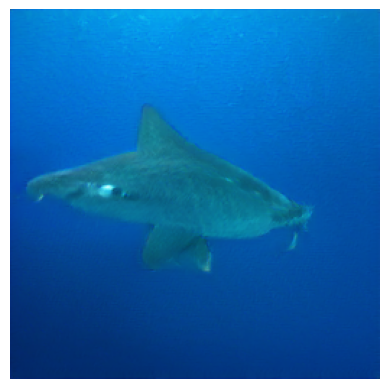

In [7]:
# Code to sample a random image

import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan')  # This is an assumed function
y = G.sample_class(batch_size=1)  # Sample class
z = G.sample_latent(batch_size=1)  # Sample latent vector
x = G(z=z, y=y)  # Generate image

# Process the image for display
x = (x + 1) / 2  # Rescale to [0, 1]
x = x.clamp(0, 1)
to_pil_image = ToPILImage()
image = to_pil_image(x.squeeze(0))  # Convert to PIL Image

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


Leveraging Pre-Trained BigGan model to create anime images via fine-tuning